In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from skimage import img_as_float
from scipy.stats import skew, kurtosis
from imagehash import phash
from collections import Counter

In [2]:
!pip install imagehash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 9.3 MB/s eta 0:00:00


In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
data_dir = '/content/drive/MyDrive/Original_Data'

In [6]:
print("Dataset path:", data_dir)
print("Exists?", os.path.exists(data_dir))
print("Subfolders:", os.listdir(data_dir))

Dataset path: /content/drive/MyDrive/Original_Data
Exists? True
Subfolders: ['not_infacted', 'infacted', 'grayworld_report.csv']


✅ Local dataset already exists at /content/Original_Data
Available class folders: ['infacted', 'not_infacted']
Using class folders: ['infacted', 'not_infacted']
Processing 741 images in class 'infacted'...


infacted images:   0%|          | 0/741 [00:00<?, ?it/s]

Processing 546 images in class 'not_infacted'...


not_infacted images:   0%|          | 0/546 [00:00<?, ?it/s]

✅ Total images processed: 1287


,R_mean,R_std,G_mean,G_std,B_mean,B_std,H_mean,H_std,S_mean,S_std,...,V_std,brightness,contrast,sat_clip_low,sat_clip_high,width,height,aspect_ratio,class,filename
0,0.683720,0.145052,0.613389,0.145971,0.515001,0.141749,0.095148,0.006458,0.256028,0.062240,...,0.145052,0.683720,0.147819,0.000000,0.000000,4032,3024,1.333333,infacted,IMG_1570.JPG
1,0.669712,0.146034,0.510899,0.145919,0.426475,0.140947,0.055943,0.007128,0.377304,0.082313,...,0.146035,0.669712,0.143262,0.000074,0.000000,4032,3024,1.333333,infacted,IMG_1756.JPG
2,0.678425,0.126894,0.500054,0.115461,0.399188,0.107800,0.058140,0.005723,0.418838,0.059115,...,0.126894,0.678425,0.117521,0.000000,0.000000,4032,3024,1.333333,infacted,IMG_1301.JPG
3,0.806383,0.117791,0.595644,0.125381,0.513357,0.123779,0.046541,0.046101,0.371322,0.078305,...,0.117791,0.806383,0.125363,0.000000,0.000000,4032,3024,1.333333,infacted,IMG_1183.JPG
4,0.706652,0.104091,0.629295,0.109978,0.540857,0.107332,0.087468,0.009487,0.239397,0.051746,...,0.104091,0.706652,0.109642,0.000000,0.000354,4032,3024,1.333333,infacted,IMG_1641.JPG


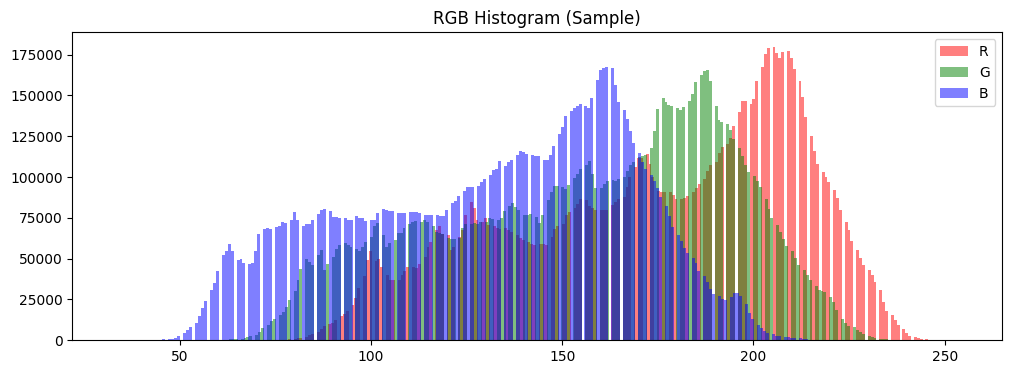

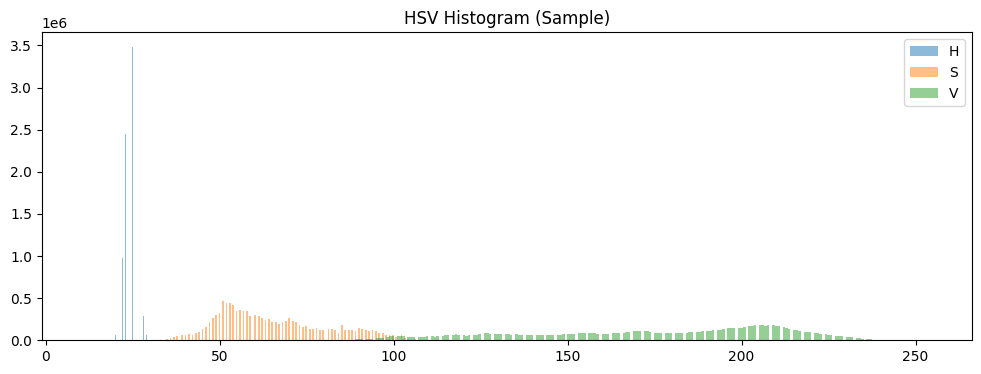

=== Per-Class Mean & STD ===


R_mean               R_std              G_mean            \
                  mean       std      mean       std      mean       std   
class                                                                      
infacted      0.684950  0.081812  0.140340  0.037378  0.545283  0.061217   
not_infacted  0.659803  0.077075  0.100049  0.039741  0.569448  0.080927   

                 G_std              B_mean            ... sat_clip_low  \
                  mean       std      mean       std  ...         mean   
class                                                 ...                
infacted      0.139184  0.035920  0.456526  0.059377  ...     0.008509   
not_infacted  0.106481  0.042616  0.496035  0.083903  ...     0.029440   

                       sat_clip_high                  width              \
                   std          mean       std         mean         std   
class                                                                     
infacted      0.029280      0.001327  0.005978  4032.000000     0.00000   
not_infacted  0.083165      0.001277  0.004610  3196.294872  1047.82375   

                   height              aspect_ratio            
                     mean          std         mean       std  
class                                                          
infacted      3024.000000     0.000000     1.333333  0.000000  
not_infacted  3656.826007  1244.889474     0.929098  0.386921  

[2 rows x 38 columns]

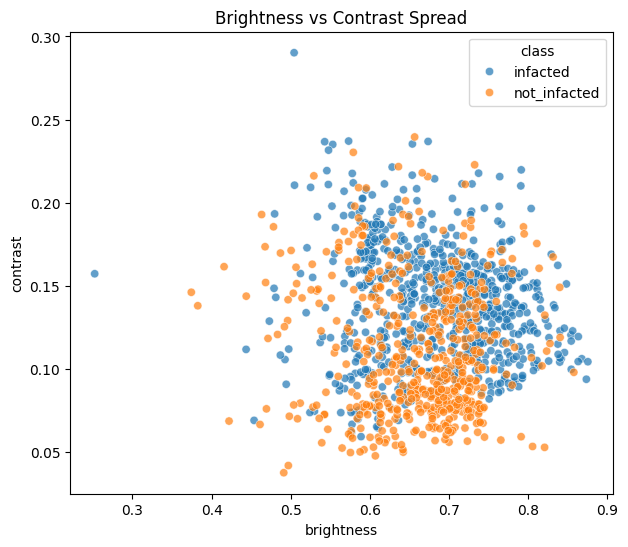

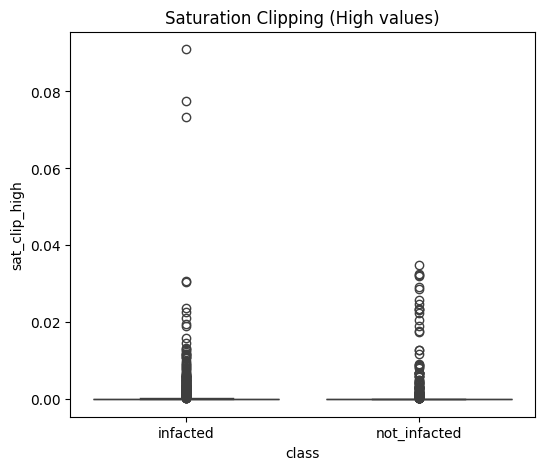

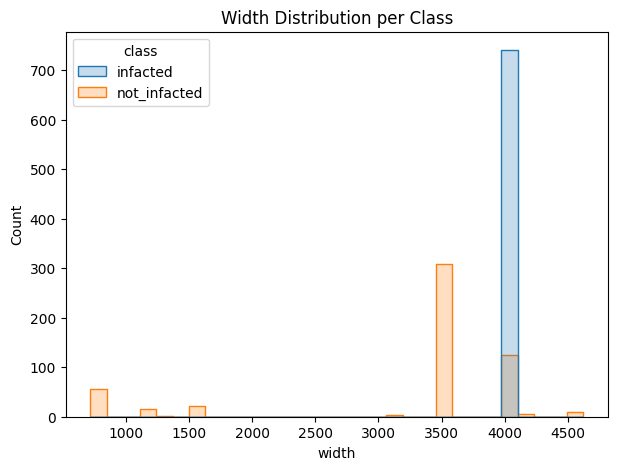

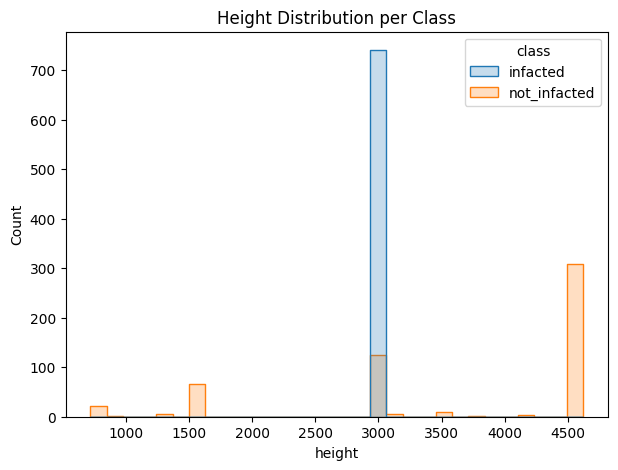

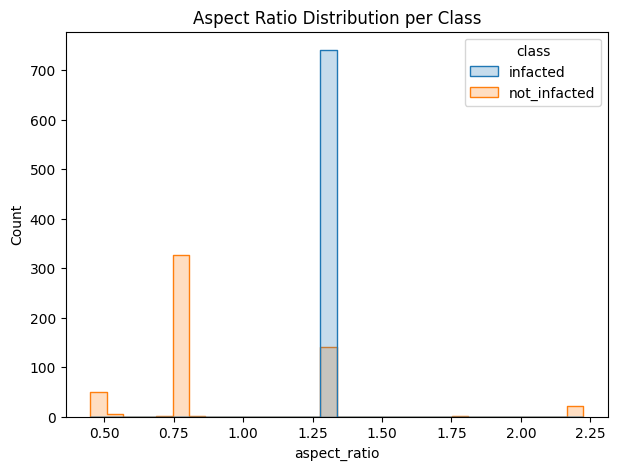

📏 Suggested resize target: (3677x3292)

💡 Suggested Strategy:
- Resize all images to fixed size (e.g., 256×256)
- Maintain aspect ratio by padding (black or mean color)
- For CNNs, random crop + resize augmentation recommended



In [18]:
# ==========================
# 0️⃣ Copy dataset locally (optional but faster)
# ==========================
LOCAL_PATH = "/content/Original_Data"
DRIVE_PATH = "/content/drive/MyDrive/Original_Data"

if not os.path.exists(LOCAL_PATH):
    shutil.copytree(DRIVE_PATH, LOCAL_PATH)
    print(f"✅ Dataset copied locally to {LOCAL_PATH}")
else:
    print(f"✅ Local dataset already exists at {LOCAL_PATH}")

# ==========================
# 1️⃣ Detect classes from folder names
# ==========================
BASE_PATH = LOCAL_PATH
available_classes = [f for f in os.listdir(BASE_PATH) if os.path.isdir(os.path.join(BASE_PATH, f))]
print(f"Available class folders: {available_classes}")

if not available_classes:
    raise ValueError("❌ No class folders found! Check dataset path.")

CLASSES = available_classes
print(f"Using class folders: {CLASSES}")

# ==========================
# 2️⃣ Helper function to compute stats
# ==========================
def compute_image_stats(image):
    if image.mode != "RGB":
        image = image.convert("RGB")

    arr = np.asarray(image, dtype=np.float32) / 255.0
    hsv = np.asarray(image.convert("HSV"), dtype=np.float32) / 255.0

    stats = {}
    for i, c in enumerate(['R', 'G', 'B']):
        stats[f'{c}_mean'] = arr[:, :, i].mean()
        stats[f'{c}_std'] = arr[:, :, i].std()
    for i, c in enumerate(['H', 'S', 'V']):
        stats[f'{c}_mean'] = hsv[:, :, i].mean()
        stats[f'{c}_std'] = hsv[:, :, i].std()

    stats['brightness'] = hsv[:, :, 2].mean()
    stats['contrast'] = arr.std(axis=(0,1)).mean()

    s = hsv[:, :, 1]
    stats['sat_clip_low'] = np.mean(s < 0.05)
    stats['sat_clip_high'] = np.mean(s > 0.95)

    stats['width'], stats['height'] = image.size
    stats['aspect_ratio'] = image.width / image.height

    return stats

# ==========================
# 3️⃣ Process all images (optimized)
# ==========================
rows = []
MAX_IMAGES = None  # Optional: test run (e.g., 200)

for cls in CLASSES:
    folder = os.path.join(BASE_PATH, cls)
    img_paths = glob.glob(os.path.join(folder, "*.*"))
    if MAX_IMAGES:
        img_paths = img_paths[:MAX_IMAGES]

    if not img_paths:
        print(f"⚠️ No images found in folder: {folder}")
        continue

    print(f"Processing {len(img_paths)} images in class '{cls}'...")
    for path in tqdm(img_paths, desc=f"{cls} images"):
        if not path.lower().endswith((".jpg", ".jpeg", ".png", ".bmp")):
            continue
        try:
            img = Image.open(path)
            stats = compute_image_stats(img)
            stats["class"] = cls
            stats["filename"] = os.path.basename(path)
            rows.append(stats)
        except:
            continue

if not rows:
    raise ValueError("❌ No valid images found! Check dataset path or folder structure.")

df = pd.DataFrame(rows)
print(f"✅ Total images processed: {len(df)}")
display(df.head())

# ==========================
# 4️⃣ Sample histogram visualization
# ==========================
sample_row = df.iloc[0]
sample_img_path = os.path.join(BASE_PATH, sample_row["class"], sample_row["filename"])
sample_img = Image.open(sample_img_path)
arr = np.asarray(sample_img)

plt.figure(figsize=(12,4))
for i,color in enumerate(['r','g','b']):
    plt.hist(arr[:,:,i].ravel(), bins=256, color=color, alpha=0.5, label=color.upper())
plt.title("RGB Histogram (Sample)")
plt.legend(); plt.show()

hsv = np.asarray(sample_img.convert("HSV"))
plt.figure(figsize=(12,4))
for i,color in enumerate(['h','s','v']):
    plt.hist(hsv[:,:,i].ravel(), bins=256, alpha=0.5, label=color.upper())
plt.title("HSV Histogram (Sample)")
plt.legend(); plt.show()

# ==========================
# 5️⃣ Per-class summary
# ==========================
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
summary = df.groupby("class")[numeric_cols].agg(["mean","std"])
print("=== Per-Class Mean & STD ===")
display(summary)

# ==========================
# 6️⃣ Brightness vs Contrast
# ==========================
plt.figure(figsize=(7,6))
sns.scatterplot(data=df, x="brightness", y="contrast", hue="class", alpha=0.7)
plt.title("Brightness vs Contrast Spread"); plt.show()

# ==========================
# 7️⃣ Saturation clipping
# ==========================
plt.figure(figsize=(6,5))
sns.boxplot(data=df, x="class", y="sat_clip_high")
plt.title("Saturation Clipping (High values)"); plt.show()

# ==========================
# 8️⃣ Resolution & Aspect Ratio
# ==========================
plt.figure(figsize=(7,5))
sns.histplot(data=df, x="width", bins=30, hue="class", element="step")
plt.title("Width Distribution per Class"); plt.show()

plt.figure(figsize=(7,5))
sns.histplot(data=df, x="height", bins=30, hue="class", element="step")
plt.title("Height Distribution per Class"); plt.show()

plt.figure(figsize=(7,5))
sns.histplot(data=df, x="aspect_ratio", bins=30, hue="class", element="step")
plt.title("Aspect Ratio Distribution per Class"); plt.show()

# ==========================
# 9️⃣ Suggested resize/padding
# ==========================
mean_w, mean_h = df['width'].mean(), df['height'].mean()
print(f"📏 Suggested resize target: ({int(mean_w)}x{int(mean_h)})")
print("""
💡 Suggested Strategy:
- Resize all images to fixed size (e.g., 256×256)
- Maintain aspect ratio by padding (black or mean color)
- For CNNs, random crop + resize augmentation recommended
""")

In [11]:
# Functions
def laplacian_variance(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    lap = cv2.Laplacian(img, cv2.CV_64F)
    return lap.var()

def noise_proxy(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    blurred = cv2.GaussianBlur(img, (3, 3), 0)
    noise = img.astype("float") - blurred.astype("float")
    return noise.var()

# Base path to your dataset in Google Drive
# Example: '/content/drive/MyDrive/ArsenicSkinImageBD/Original'
base_path = '/content/drive/MyDrive/Original_Data'
categories = ['infacted', 'not_infacted']

data = []

# Loop through each folder and image
for category in categories:
    folder_path = os.path.join(base_path, category)
    for filename in tqdm(os.listdir(folder_path)):
        img_path = os.path.join(folder_path, filename)
        lap_var = laplacian_variance(img_path)
        noise_val = noise_proxy(img_path)

        data.append({
            'filename': filename,
            'category': category,
            'laplacian_variance': lap_var,
            'noise_proxy': noise_val
        })

# Create DataFrame
df = pd.DataFrame(data)

# Save to CSV in Colab
output_csv = '/content/laplacian_noise_results.csv'
df.to_csv(output_csv, index=False)
print(f"CSV saved to {output_csv}")

# Show mean stats by category
print(df.groupby('category')[['laplacian_variance', 'noise_proxy']].mean())

100%|██████████| 546/546 [03:27<00:00,  2.64it/s]

CSV saved to /content/laplacian_noise_results.csv
              laplacian_variance  noise_proxy
category                                     
infacted               22.096996     1.227764
not_infacted           30.358032     1.568775


In [12]:
from PIL import Image
import numpy as np
import os, glob, itertools
import pandas as pd
from tqdm.notebook import tqdm

# -------------------------------
# 0) Image folder path
# -------------------------------
IMAGE_FOLDER = "/content/drive/MyDrive/Original_Data"

# -------------------------------
# 1) Gray-World White Balance Function
# -------------------------------
def gray_world_correction(pil_image):
    if pil_image.mode != 'RGB':
        pil_image = pil_image.convert('RGB')
    arr = np.asarray(pil_image).astype(np.float32)

    mean_r = arr[:, :, 0].mean()
    mean_g = arr[:, :, 1].mean()
    mean_b = arr[:, :, 2].mean()
    mean_gray = (mean_r + mean_g + mean_b) / 3.0

    scale_r = mean_gray / mean_r
    scale_g = mean_gray / mean_g
    scale_b = mean_gray / mean_b

    arr[:, :, 0] = np.clip(arr[:, :, 0] * scale_r, 0, 255)
    arr[:, :, 1] = np.clip(arr[:, :, 1] * scale_g, 0, 255)
    arr[:, :, 2] = np.clip(arr[:, :, 2] * scale_b, 0, 255)

    return Image.fromarray(arr.astype(np.uint8))

# -------------------------------
# 2) Perceptual Hashing Functions (aHash + dHash)
# -------------------------------
def ahash(image, hash_size=8):
    image = image.convert('L').resize((hash_size, hash_size), Image.Resampling.LANCZOS)
    pixels = np.array(image)
    avg = pixels.mean()
    return ''.join(['1' if p > avg else '0' for p in pixels.flatten()])

def dhash(image, hash_size=8):
    image = image.convert('L').resize((hash_size + 1, hash_size), Image.Resampling.LANCZOS)
    pixels = np.array(image)
    diff = pixels[:, 1:] > pixels[:, :-1]
    return ''.join(['1' if v else '0' for v in diff.flatten()])

def hamming_distance(hash1, hash2):
    return sum(c1 != c2 for c1, c2 in zip(hash1, hash2))

# -------------------------------
# 3) Process Images
# -------------------------------
image_paths = glob.glob(os.path.join(IMAGE_FOLDER, '**', '*.*'), recursive=True)
image_paths = [p for p in image_paths if p.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]

print(f"🔍 Total image paths found: {len(image_paths)}")
if len(image_paths) > 0:
    print("First few image paths:", image_paths[:3])

rows = []
for img_path in tqdm(image_paths, desc="Processing images"):
    try:
        img = Image.open(img_path)
        wb_img = gray_world_correction(img)
        row = {
            "filename": os.path.basename(img_path),
            "path": img_path,
            "width": img.width,
            "height": img.height,
            "ahash": ahash(img),
            "dhash": dhash(img)
        }
        rows.append(row)
    except Exception as e:
        print(f"⚠️ Error processing {img_path}: {e}")

print("✅ Number of rows collected:", len(rows))
if len(rows) > 0:
    print("Sample keys:", list(rows[0].keys()))

# -------------------------------
# 4) DataFrame Creation (with debug protection)
# -------------------------------
if not rows:
    print("❌ No valid image data found — check your IMAGE_FOLDER path or image formats.")
else:
    df = pd.DataFrame(rows)

    if "filename" in df.columns:
        df = df.sort_values("filename").reset_index(drop=True)
        print("✅ === Image analysis results ===")
        display(df.head())
    else:
        print("⚠️ 'filename' column missing — showing raw DataFrame instead.")
        display(df)

    # -------------------------------
    # 5) Duplicate Detection
    # -------------------------------
    duplicates = []
    threshold = 5  # max hamming distance to consider duplicate

    for (i1, row1), (i2, row2) in itertools.combinations(df.iterrows(), 2):
        hd_ahash = hamming_distance(row1['ahash'], row2['ahash'])
        hd_dhash = hamming_distance(row1['dhash'], row2['dhash'])
        if hd_ahash <= threshold and hd_dhash <= threshold:
            duplicates.append({
                "file1": row1['filename'],
                "file2": row2['filename'],
                "ahash_dist": hd_ahash,
                "dhash_dist": hd_dhash
            })

    dup_df = pd.DataFrame(duplicates)
    print("✅ === Duplicates found ===")
    if not dup_df.empty:
        display(dup_df)
    else:
        print("No duplicates detected ✅")


🔍 Total image paths found: 1287
First few image paths: ['/content/drive/MyDrive/Original_Data/not_infacted/IMG-20230529-WA0055.jpg', '/content/drive/MyDrive/Original_Data/not_infacted/IMG-20230529-WA0003.jpg', '/content/drive/MyDrive/Original_Data/not_infacted/IMG20230610175446.jpg']


Processing images:   0%|          | 0/1287 [00:00<?, ?it/s]

✅ Number of rows collected: 1287
Sample keys: ['filename', 'path', 'width', 'height', 'ahash', 'dhash']
✅ === Image analysis results ===


,filename,path,width,height,ahash,dhash
0,IMG-20230529-WA0000.jpg,/content/drive/MyDrive/Original_Data/not_infac...,719,1600,0000000000000000000000011000011111011111111111...,1011011111101010011011110011110100110100100101...
1,IMG-20230529-WA0001.jpg,/content/drive/MyDrive/Original_Data/not_infac...,719,1600,0000111100111111011011010100110100010111000101...,0111101101101111110110011101100111110100011101...
2,IMG-20230529-WA0002.jpg,/content/drive/MyDrive/Original_Data/not_infac...,719,1600,0000011100001111000001110000011100001111000011...,1111111011111110011111101110111011101100111011...
3,IMG-20230529-WA0003.jpg,/content/drive/MyDrive/Original_Data/not_infac...,1600,719,0101111111001111110011101000000010000100000001...,1001101110011010000110100010100100111101001011...
4,IMG-20230529-WA0004.jpg,/content/drive/MyDrive/Original_Data/not_infac...,719,1600,0000111100001111000001110000011101111111111111...,1111111000111110111111101110111111011011110000...


✅ === Duplicates found ===


,file1,file2,ahash_dist,dhash_dist
0,IMG-20230529-WA0019.jpg,IMG-20230529-WA0067.jpg,2,2
1,IMG-20230529-WA0021.jpg,IMG-20230529-WA0060.jpg,4,4
2,IMG-20230529-WA0021.jpg,IMG_20230612_130410.jpg,2,5
3,IMG-20230529-WA0042.jpg,IMG-20230529-WA0046.jpg,4,3
4,IMG-20230529-WA0042.jpg,IMG20230610182635.jpg,5,4
...,...,...,...,...
77,IMG_20230612_130815.jpg,IMG_20230612_130817.jpg,4,2
78,IMG_20230616_153459.jpg,IMG_20230616_153500.jpg,3,1
79,IMG_2025.JPG,IMG_2026.JPG,1,2
80,IMG_2074.JPG,IMG_2075.JPG,1,5


Dataset path: /content/drive/MyDrive/Original_Data
Exists? True
Subfolders: ['not_infacted', 'infacted', 'grayworld_report.csv']
Total files found recursively: 1288

 Total samples loaded: 1287
                                            filepath         label  \
0  /content/drive/MyDrive/Original_Data/not_infac...  not_infacted   
1  /content/drive/MyDrive/Original_Data/not_infac...  not_infacted   
2  /content/drive/MyDrive/Original_Data/not_infac...  not_infacted   
3  /content/drive/MyDrive/Original_Data/not_infac...  not_infacted   
4  /content/drive/MyDrive/Original_Data/not_infac...  not_infacted   

                 group  
0  IMG-20230529-WA0055  
1  IMG-20230529-WA0003  
2    IMG20230610175446  
3    IMG20230610175655  
4  IMG-20230529-WA0047  

 Class distribution:
not_infacted: 546
infacted: 741

 Split summary:
Train size: 304
Test size: 983


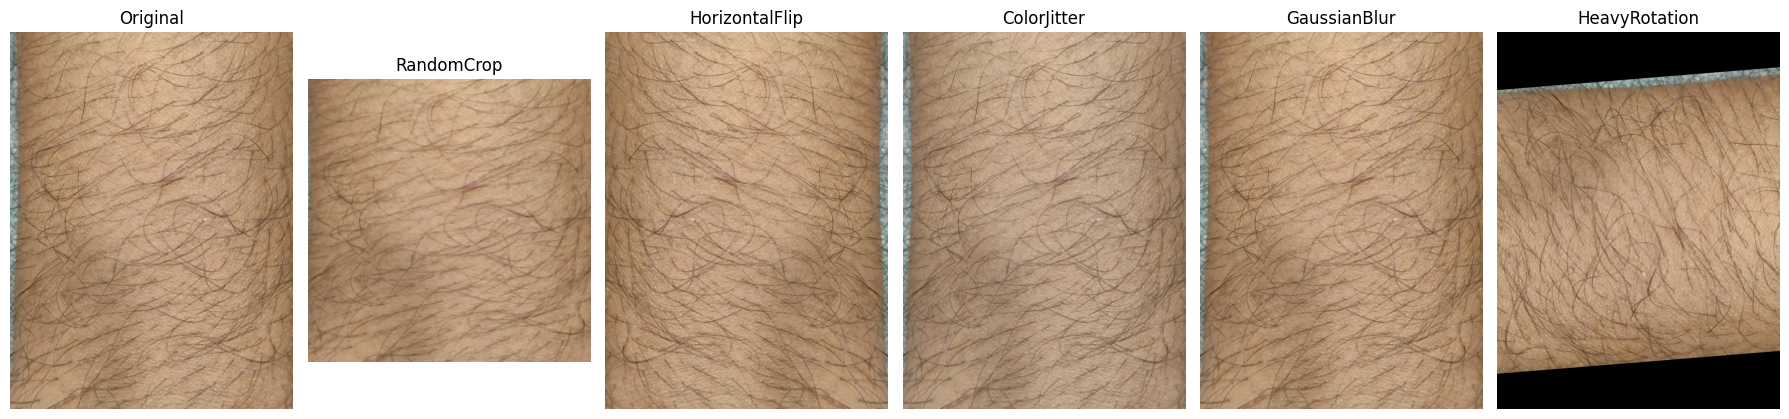


 Augmentation probe complete — visually inspect which transforms help or hurt.


In [15]:
# ===============================
# STEP 1: Set dataset path & verify
# ===============================
import os

data_dir = '/content/drive/MyDrive/Original_Data'  #  Adjust if needed

print("Dataset path:", data_dir)
print("Exists?", os.path.exists(data_dir))
print("Subfolders:", os.listdir(data_dir))

# ===============================
# STEP 2: Recursively scan for JPG files & build DataFrame
# ===============================
import pandas as pd
import glob

# Accept both lower & upper case extensions
valid_ext = ('.jpg', '.jpeg', '.JPG', '.JPEG', '.png', '.PNG')

# Recursively collect file paths
file_paths = glob.glob(os.path.join(data_dir, '**', '*.*'), recursive=True)
print("Total files found recursively:", len(file_paths))

rows = []
for fpath in file_paths:
    if fpath.endswith(valid_ext):
        # Label = parent folder name (e.g., 'infacted', 'not_infacted')
        label = os.path.basename(os.path.dirname(fpath))
        # Group ID = filename stem or prefix before underscore
        fname = os.path.basename(fpath)
        group_id = fname.split("_")[0] if "_" in fname else fname.split(".")[0]
        rows.append([fpath, label, group_id])

df = pd.DataFrame(rows, columns=["filepath", "label", "group"])
print("\n Total samples loaded:", len(df))
print(df.head())

if len(df) == 0:
    raise ValueError(" No image files found. Check dataset structure or path.")

# ===============================
# STEP 3: Class distribution check
# ===============================
from collections import Counter

class_counts = Counter(df['label'])
print("\n Class distribution:")
for cls, count in class_counts.items():
    print(f"{cls}: {count}")

# ===============================
# STEP 4: Grouped train-test split (to avoid leakage)
# ===============================
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_idx, test_idx = next(gss.split(df['filepath'], df['label'], groups=df['group']))

train_df = df.iloc[train_idx].reset_index(drop=True)
test_df = df.iloc[test_idx].reset_index(drop=True)

print("\n Split summary:")
print("Train size:", len(train_df))
print("Test size:", len(test_df))

# ===============================
# STEP 5: Augmentation Probe (Safe vs Harmful)
# ===============================
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt

# Pick a random training image
sample_path = train_df['filepath'].sample(1, random_state=42).iloc[0]
img = Image.open(sample_path)

augmentations = {
    "RandomCrop": T.RandomResizedCrop(size=244, scale=(0.8, 1.0)),
    "HorizontalFlip": T.RandomHorizontalFlip(p=1.0),
    "ColorJitter": T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    "GaussianBlur": T.GaussianBlur(kernel_size=5),
    "HeavyRotation": T.RandomRotation(degrees=90),  # potential harmful
}

fig, axes = plt.subplots(1, len(augmentations)+1, figsize=(18,5))
axes[0].imshow(img)
axes[0].set_title("Original")
axes[0].axis("off")

for i, (name, aug) in enumerate(augmentations.items(), 1):
    transformed = aug(img)
    axes[i].imshow(transformed)
    axes[i].set_title(name)
    axes[i].axis("off")

plt.tight_layout()
plt.show()

print("\n Augmentation probe complete — visually inspect which transforms help or hurt.")
